In [24]:
import numpy as np
import matplotlib.pyplot as plt


In [25]:
def softmax(x):
    y = np.exp(x)
    return y/np.sum(y)


def ExpBernoulliAlt(c,lam,size=None,method='poisson',N=1000): # returns True with probability $e^{c-lam}$
    if size is None: 
        size = (1,)
    if type(size) is int:
        size = (size,)
    elif type(size) is not tuple:
        raise TypeError("size must be int or tuple")
    
    if method == 'poisson':
        M=np.random.poisson(lam=lam,size=size) # Get integers from poisson(lam).
    elif method == 'binomial': # N is number to flip
        M=np.random.binomial(N,lam/N,size=size)

    # if type(c) is float:
    spikes = np.random.random(size)<np.power(c/lam,M) # Spike if all K trials are successful
    return spikes

Start with a unit norm query, q, key and value matrices Q and V. We want to do a spiking verysion of softmax(qK)V. 

For doing qK, we can use AND and OR gates as long as the spiking are random and independent and have low enough probability. I think. 

In [26]:
N=256
# M=100
K=20000
# x_prob,y_prob = np.random.random(N)/10,np.random.random(N)/10 # spike probability of each neuron
x_prob,y_prob = np.abs(np.random.normal(0, 1./10, N)),np.abs(np.random.normal(0, 1./10, N)) # spike probability of each neuron

xs = np.random.random((K,N)) < x_prob   # K x N matrix of boolean spikes for neuron x
ys = np.random.random((K,N)) < y_prob   # K x N matrix of boolean spikes for neuron y
mask = np.random.random((K,N)) < 1/np.sqrt(N) # K x N matrix of boolean mask

zs = xs & ys & mask # K vector of boolean ANDs, then averaged over neurons
output_spike_train = np.any(zs, axis=1) # K vector of boolean ORs
approx = np.mean(output_spike_train) # average over K trials
exact = np.dot(x_prob,y_prob)/np.sqrt(N)
# exact = np.prod(np.dot(x_prob,y_prob)/np.sqrt(N))
percent_error = np.abs(approx - exact) / exact * 100
angle = np.arccos(np.dot(x_prob,y_prob)/np.sqrt(np.dot(x_prob,x_prob)*np.dot(y_prob,y_prob)))

print("Exact product: ", round(exact, 5))
print("Approximate product: ", round(approx, 5))
print("Percent error: ", round(percent_error, 5), "%")
print("Angle: ", round(angle, 5), " radians")


Exact product:  0.09013
Approximate product:  0.08405
Percent error:  6.7464 %
Angle:  0.91978  radians


Approx:  [0.00196 0.0015  0.00152 0.0016  0.00128 0.00138 0.00146 0.00142 0.00136
 0.00124 0.0016  0.0012  0.0014  0.00146 0.00132 0.00132 0.00138 0.00148
 0.00124 0.0012 ]
Exact:  [[0.002      0.00150811 0.00144612 0.00145582 0.00132739 0.00138014
  0.0014631  0.00149716 0.00152937 0.00152663 0.0014444  0.00142159
  0.00135183 0.00143797 0.00143591 0.00144074 0.0014383  0.00151935
  0.00133107 0.00131041]]
Error : 0.032202687947090025
Ratios:  [[0.98       0.99462099 1.05108667 1.09903407 0.96429497 0.99989942
  0.99787923 0.94845991 0.88925541 0.8122449  1.10772767 0.84412464
  1.03563071 1.01532158 0.9192772  0.91619864 0.95946749 0.97409907
  0.93158228 0.91574142]]


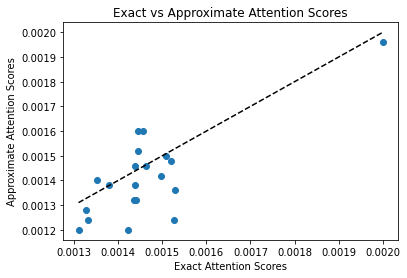

In [38]:
dm=100
n_keys=20
M=n_keys
# M=100
T=50000
lam=2.5
# R=20000
# x_prob,y_prob = np.random.random(N)/10,np.random.random(N)/10 # spike probability of each neuron
q,K = np.abs(np.random.normal(0, 1./10, (dm,1))),np.abs(np.random.normal(0, 1./10, (dm,n_keys))) # spike probability of each neuron
q,K=np.random.random((dm,1)),np.random.random((dm,n_keys))
# K[:,0]=K[:,0]*0.5+q[:,0]*0.5
# K[:,1]=K[:,1]*0.8+q[:,0]*0.2
K[:,0]=q[:,0]
# Normalize
K /= np.sqrt(np.sum(K**2,axis=0,keepdims=True))
q /= np.sqrt(np.sum(q**2,axis=0,keepdims=True))

V = np.random.random((dm,n_keys))-0.5   # Value matrix

# Baseline using continuous values
attn_scores = q.T@K/(50*np.sqrt(dm))

# Spiking approximation
q_spikes = np.random.random((T,dm,1))<q
K_spikes = np.random.random((T,dm,n_keys))<K
mask = np.random.random((T,dm,n_keys)) < 1/(50*np.sqrt(dm)) # K x N matrix of boolean mask
attn_score_spikes = q_spikes & K_spikes & mask

attn_score_spikes = np.any(attn_score_spikes, axis=1)
# attn_score_spikes = np.sum(attn_score_spikes, axis=1)

approx_attn_scores = np.mean(attn_score_spikes, axis=0)

# Compare
print("Approx: ",approx_attn_scores)
print("Exact: ",attn_scores)
print("Error :",1-np.mean(approx_attn_scores/attn_scores))
print("Ratios: ",approx_attn_scores/attn_scores)

# Scatter plot
# plt.scatter(attn_scores, approx_attn_scores)

# Add labels and title
plt.xlabel('Exact Attention Scores')
plt.ylabel('Approximate Attention Scores')
plt.title('Exact vs Approximate Attention Scores')

# Scatter plot
plt.scatter(attn_scores, approx_attn_scores)
# Add y=x line
plt.plot([np.min(attn_scores), np.max(attn_scores)], [np.min(attn_scores), np.max(attn_scores)], color='black', linestyle='dashed')

# Show the plot
plt.show()



In [34]:

outs=[]
for trial in range(500):
    T=np.random.poisson(lam=lam,size=1)[0] # Get integers from poisson(lam). Number of successes needs
    # Spiking approximation
    q_spikes = np.random.random((T,dm,1))<q
    K_spikes = np.random.random((T,dm,n_keys))<K
    mask = np.random.random((T,dm,n_keys)) < 1/np.sqrt(dm) # K x N matrix of boolean mask
    attn_score_spikes = q_spikes & K_spikes & mask
    sum_spikes = np.any(attn_score_spikes, axis=1)
    out = np.all(sum_spikes, axis=0,keepdims=True)
    # flips = np.random.random((T,M))<lam/T
    # lam_invert = np.random.random((T,M))<1/lam
    # # ~flips | (sum_spikes & lam_invert)
    # out = np.all(~flips | (sum_spikes & lam_invert), axis=0,keepdims=True)
    outs.append(out)
outs = np.concatenate(outs,axis=0)
mean_out = np.mean(outs,axis=0)
print("Approx :",mean_out)
print("Exact: ",attn_scores)
print("Error :",1-np.mean(mean_out/attn_scores))
print("Ratios: ",mean_out/attn_scores)


# q_spikes = np.random.random((T,N,1))<q
# K_spikes = np.random.random((T,N,M))<K
# mask = np.random.random((T,N,M)) < 1/np.sqrt(N) # K x N matrix of boolean mask
# score_spikes = q_spikes & K_spikes & mask
# sum_spikes = np.any(score_spikes, axis=1)
# flips = np.random.random((T,M))<lam/T
# lam_invert = np.random.random((T,M))<1/lam
# # ~flips | (sum_spikes & lam_invert)
# out = np.all(~flips | (sum_spikes & lam_invert), axis=0,keepdims=True)
# # print(np.shape(out))
# print(out/attn_scores)
# # sum_spikes_reduced = sum_spikes @
# # mean_spikes = np.mean(sum_spikes, axis=0,keepdims=True)
# # print(np.shape(sum_spikes))
# print(np.shape(attn_scores))
# error = mean_spikes-attn_scores
# print(np.sqrt(np.mean(error**2)))
# print(np.sqrt(np.mean(attn_scores**2)))




Approx : [0.096 0.094 0.084 0.082 0.092 0.084 0.082 0.088 0.086 0.102 0.094 0.088
 0.098 0.09  0.094 0.092 0.102 0.09  0.086 0.086]
Exact:  [[0.1        0.07591026 0.07393153 0.07666985 0.07402809 0.07000596
  0.07088452 0.07685    0.07300686 0.07437543 0.07594129 0.0762364
  0.07551446 0.07362136 0.07728051 0.0743656  0.07741174 0.07859786
  0.07764515 0.07697252]]
Error : -0.1875686704183599
Ratios:  [[0.96       1.23830431 1.13618638 1.06952086 1.24277148 1.1998978
  1.15681105 1.14508782 1.17797154 1.37142056 1.23779838 1.15430417
  1.29776473 1.22247129 1.21634811 1.23713111 1.31762962 1.14506933
  1.10760304 1.11728183]]
